In [1]:
# Gain modulation RNN with hebbian learning on weight matrix
import numpy as np
import sys
sys.path.append("..")
from rnn import RNN
import matplotlib.pyplot as plt
import json
import torch

## Loading Trained Weights

In [2]:
with open('../weights/MacheyGlass_hebb_128_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 3000 #ms
num_inputs = 1
num_nodes = 128
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

In [6]:
# Defining Inputs and Targets
def generate_MackeyGlass(ntimes, tau):
    # initial condition
    # x_values = np.random.uniform(0,1,tau).tolist()
    x_values = [0.1]*tau

    def mackey_glass(x, tau, gamma=0.1, beta0=0.2, n=10):
        dxdt = beta0 * x[-tau] / (1 + x[-tau]**n) - gamma * x[-1]
        return dxdt

    x_t = x_values[-1]
    for t in range(ntimes):
        dxdt = mackey_glass(x_values, tau)
        x_t = x_t + dxdt
        x_values.append(x_t)

    x = x_values[tau:]
    return x

total_time_steps = 300
tau = 20
MG_sequence = np.array(generate_MackeyGlass(total_time_steps+1, tau))
inputs = MG_sequence[0:300].reshape(-1,1)
targets = MG_sequence[1:301].reshape(-1,1)

100%|██████████| 300/300 [00:00<00:00, 7114.50it/s]


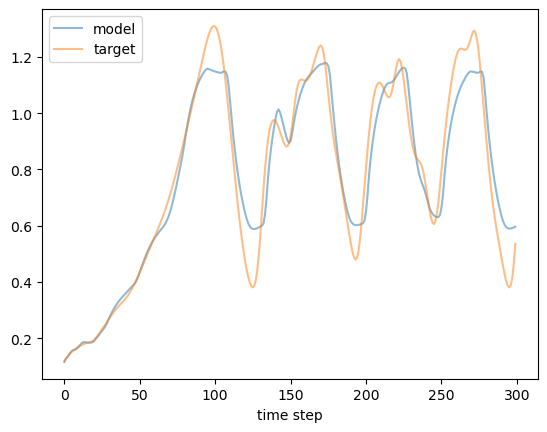

In [7]:
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights)
fig, ax = plt.subplots()
plt.plot(np.arange(300), outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(np.arange(300), targets, alpha=0.5, label='target')
plt.xlabel("time step")
plt.legend()
plt.savefig("fig/MG_hebb_train.png")

100%|██████████| 300/300 [00:00<00:00, 12394.52it/s]


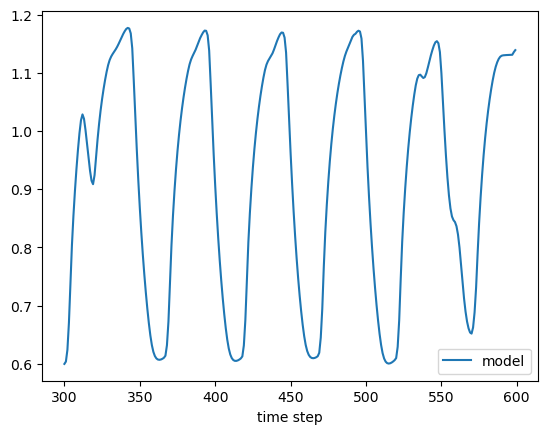

In [8]:
time_pred = 3000

total_time_steps = 600
tau = 20
MG_sequence = np.array(generate_MackeyGlass(total_time_steps+1, tau))
inputs_pred = MG_sequence[300:600].reshape(-1,1)

outputs_pred, activations_pred = network.simulate(time_pred, torch.tensor(inputs_pred).float(), input_weights)
fig, ax = plt.subplots()
plt.plot(np.arange(300,600), outputs_pred.detach().numpy(), label='model')
plt.xlabel("time step")
plt.legend()
plt.savefig("fig/MG_hebb_pred.png")

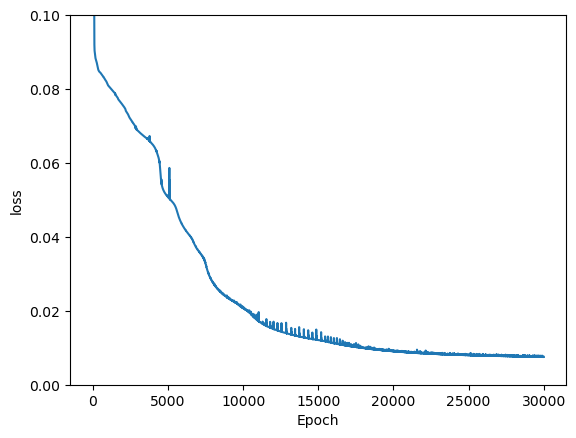

In [9]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.1])
plt.savefig("fig/MG_hebb_loss.png")